In this notebook we aim to improve model performances by using Morgan fingerprints in combination with relatively simple Neural Networks (NN) implemented using the PyTorch libraries.

First we read in the same training and test data as for previous models:

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys

# display 3 significant digits when printing pandas dataframes
pd.options.display.precision = 3
np.set_printoptions(precision=3)

# Choose a target
target = "NR-AR"

# import the processed dataset for algorithms what require scaled variables
print('Load Pickle')
pickle_in = open(target + "_processeddata.pkl", "rb")
[param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test] = pickle.load(pickle_in)
pickle_in.close()
print('Finished')

Load Pickle
Finished


We generate Morgan fingerprints from the SMILES of each compound. For each molecular compound, a fingerprint of length 2048 is generated.

In [2]:
# import the rdkit submodules for fingerprint calculations
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import rdFingerprintGenerator
import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)

# create mol objects using the training set SMILES
mols_train = [MolFromSmiles(smi) for smi in train_smi]
# calculate the fingerprints and store them as numpy arrays (1D) in a list
fpgen_morgan2 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
ecfps_train = [np.array(fpgen_morgan2.GetFingerprint(mol)) for mol in mols_train]
# convert the list of 1D numpy arrays into a 2D array by stacking the entries
fp_train = np.vstack(ecfps_train)
print(f'Fingerprint train matrix shape: {fp_train.shape}')

# create mol objects using the test set SMILES
mols_test = [MolFromSmiles(smi) for smi in test_smi]
# calculate the fingerprints and store them as numpy arrays (1D) in a list
ecfps_test = [np.array(fpgen_morgan2.GetFingerprint(mol)) for mol in mols_test]
# convert the list of 1D numpy arrays into a 2D array by stacking the entries
fp_test = np.vstack(ecfps_test)
print(f'Fingerprint test matrix shape: {fp_test.shape}')


[13:52:55] WARNING: not removing hydrogen atom without neighbors


Fingerprint train matrix shape: (5812, 2048)
Fingerprint test matrix shape: (1453, 2048)


Convert the molecular fingerprint arrays to PyTorch tensor format for training and test data. Also convert the corresponding arrays with toxicity labels. Create minibatches to speed up the optimization of the parameters.

In [3]:
import torch # the PyTorch module is referred to as torch
from torch import nn # the neural network module is referred to as nn
from torch.nn import functional as F # abbreviate "functional" to "F" for easy reference

# convert the features and labels to tensor format
tens_train = torch.tensor(fp_train, dtype = torch.float32) # the dtype "float" means "floating-point number"
tens_test = torch.tensor(fp_test, dtype = torch.float32)
label_train = torch.tensor(y_train.astype(int), dtype = torch.long) # the dtype "long" means "integers"
label_test = torch.tensor(y_test.astype(int), dtype = torch.long)

# the size of tensors can be examined with .shape, the same way as np arrays
print(tens_train.shape, label_train.shape)
print(tens_test.shape, label_test.shape)

torch.Size([5812, 2048]) torch.Size([5812])
torch.Size([1453, 2048]) torch.Size([1453])


In [4]:
from torch import optim
from torch.utils import data
from sklearn import metrics

# set the size of each minibatch
batch_size = 100
# create a PyTorch dataset with the training data
train_data = data.TensorDataset(tens_train, label_train)
# create minibatches of the specified size
cloader = data.DataLoader(train_data, batch_size=batch_size)

print("number of minibatches")
print(len(list(cloader))) 

number of minibatches
59


Write a class for a NN with three hidden layers. Each hidden layer uses a ReLu function at the nodes. Dropout layers are provided at the input and the second hidden layer. Notice we have not defined any function on the output yet (and thus values are in principle not bounded yet).

In [5]:
hidden_len_1 = 100 # the number of neurons in the first hidden layer
hidden_len_2 = 50 # the number of neurons in the second hidden layer
hidden_len_3 = 20 # the number of neurons in the second hidden layer

class NN_classification(nn.Module):
    """
    inputs upon initializetion:
    in_len (int, positive): number of input features
    out_len (int, positive): number of output features
    drop_ratio (float, [0,1), optional): portion of data ignored on dropout layers;
                               the same setting will be applied to all dropout layers
    output upon optimization: training loss
    """
    def __init__(self, in_len, out_len, dropout_ratio=0):
        # call the parent class before making assignments
        super().__init__()
        # initialize all the layers to be used
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1 = nn.Linear(in_len, hidden_len_1)
        self.layer2 = nn.Linear(hidden_len_1, hidden_len_2)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer3 = nn.Linear(hidden_len_2, hidden_len_3)
        self.output = nn.Linear(hidden_len_3, out_len)

    # structure the forward pass
    def forward(self, x):
        # dropout on the input layer
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # dropout on the second hidden layer
        x = self.dropout2(x)
        x = F.relu(self.layer3(x))
        x = self.output(x) # linear output layer
        return(x)

Next we write a function for training the NN and make it possible to follow the training loss, accuracy, sensitivity and precision. Optimization with L1 or L2 regularization is also implemented.

In [6]:
# codes adapted from the pytorch tutorial page
def train_loop(dataloader, model, loss_fn, optimizer, l1=0, l2=0):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0

    all_preds = []
    all_labels = []

    for batch, (X, y) in enumerate(dataloader): # loop to iterate over the batches, X stores the features,
        # y stores the labels
        # forward propagation, compute prediction and loss
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y.float())

        # calculate the L1 & L2 penalty terms
        l1_norm = sum(p.abs().sum() for p in model.parameters()) # sum of the absolute values of the weights
        # of the model
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # sum of the squared values of the weights of
        # the model
        l1_reg = l1 * l1_norm # l1 and l2 are equivalent to alpha (regularization factor) in linear models
        l2_reg = l2 * l2_norm
        # adjust the loss to include the penalty terms
        loss = loss + l1_reg + l2_reg
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        y_pred = torch.sigmoid(pred).float() > 0.5  # Binary predictions (threshold=0.5)
        all_preds.extend(y_pred.tolist()) # extend predictions list with the current batch
        all_labels.extend(y.tolist()) # extend labels list with the current batch
    
    all_preds = np.array(all_preds) # convert the list to a numpy array
    all_labels = np.array(all_labels) # convert the list to a numpy array

    # calculate the accuracy
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    precision = metrics.precision_score(all_labels, all_preds)
    sensitivity = metrics.recall_score(all_labels, all_preds)

    train_loss /= len(dataloader) # average training loss over all batches
    # no need to return the model, as it is being updated inplace
    return(train_loss, accuracy, precision, sensitivity)

We also implement an early stopper class which further splits the training data into a new training set and a validation set. The validation function follows performance of the model that is being trained on the validation data which in this case is not used for training. When the performance on the validation data does not improve for a certain amount of cycles (aka epochs), the model optimization is stopped. The model can then be set back to where it performed best on the validation data.

In [7]:
class EarlyStopper:
    """
    patience: number of epochs without improvement allowed before calling for the training to be stopped
    min_delta: minimum difference expected between previous and current validation score to consider that
    improvement occured
    """
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss_val = float('inf')

    def early_stop(self, loss_val):
        if loss_val < (self.min_loss_val - self.min_delta): # improvement observed
            self.min_loss_val = loss_val
            self.counter = 0
        elif loss_val > self.min_loss_val: # strictly no improvement / worse performance
            self.counter += 1
            if self.counter >= self.patience:
                return True
        # here the cycles where slight improvements (below min_delta) are observed will be ignored
        # doesn't reset the counter&criterion but also wouldn't add to the countdown
        return False

# pack the validation step into a function
def validation_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    val_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X).view(-1) # forward pass converting the output to a 1D tensor
            y = y.float().view(-1) # convert the labels to float
            loss = loss_fn(pred, y) # calculate the loss
            val_loss += loss.item() # accumulate the loss
    val_loss /= len(dataloader) # average validation loss over all batches

    return(val_loss)

We have now implemented all classes and functions necessary to start optimizing our Neural Network. The NN has 2048 input nodes corresponding to 2048 logits of each fingerprint and one output node designating the toxicity label (toxic or non-toxic).

We first optimize a NN without early stopping. As loss function, we use the Binary Cross-Entropy (BCE) Loss, which is very suitable for binary classification. The `BCEWithLogitsLoss` function applies the sigmoid function internally before calculating the BCE Loss (and thus makes it part of the optimization scheme). To deal with the imbalance in the dataset, we weight the BCE loss function according to the positive class weight. 

As optimizer, we use stochastic gradient descent `SGD`. We also implement small regularization factors and a small learning rate.

Number of features: 2048


Text(0, 0.5, 'Average Loss')

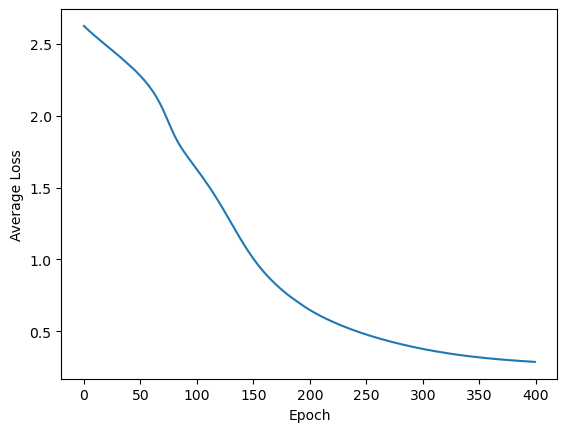

In [8]:
in_len = fp_train.shape[1] # calculate the number of features (in this case the number of bits in the fingerprint)
print(f'Number of features: {in_len}')
out_len = 1 # logit: 1 output unit for binary classification
torch.random.manual_seed(500) # set up random seed to initialize weights

lr = 0.002 # learning rate
epochs = 400 # number of epochs

# if this variable already exists, remove it
try:
    del c_net
except:
    pass

c_net = NN_classification(in_len, out_len) # create an instance of the neural network

# Compute class imbalance
non_toxic = sum(y_train == 0)
toxic = sum(y_train == 1)
pos_weight = torch.tensor([non_toxic / toxic], dtype=torch.float32) # Set positive class weight

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # the loss function is the cross-entropy loss
optimizer = optim.SGD(c_net.parameters(), lr=lr) # the optimizer is stochastic gradient descent

loss_list = [] 
acc_list = []
prec_list = []
sens_list = []
# training
for e in range(epochs):
    loss, acc, prec, sens = train_loop(cloader, c_net, loss_fn, optimizer, l1=5e-4, l2=1e-4)
    loss_list.append(loss)
    acc_list.append(acc)
    prec_list.append(prec)
    sens_list.append(sens)

plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

# print(c_net(tens_train)) # check the output shape



We clearly see the average loss decreases over the epochs, and seems to converge for the training data. We now check how the optimized model performs on training and test data.

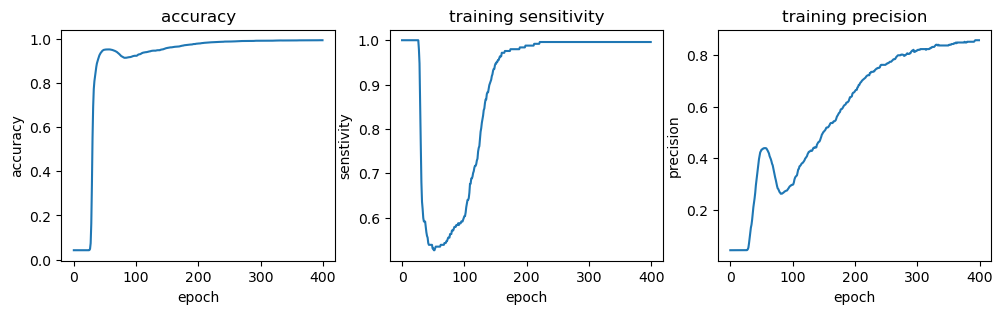

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
ax1.plot(acc_list)
ax1.title.set_text('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.plot(sens_list)
ax2.title.set_text('training sensitivity')
ax2.set_xlabel('epoch')
ax2.set_ylabel('senstivity')
ax3.plot(prec_list)
ax3.title.set_text('training precision')
ax3.set_xlabel('epoch')
ax3.set_ylabel('precision')
plt.show()

In [24]:
threshold = 0.5 # set the threshold for the sigmoid function

train_preds = torch.sigmoid(c_net(tens_train)) # calculate the predictions
# print(f'Predictions: {train_preds}')
y_pred_train = (train_preds > threshold).float() # convert the predictions to binary values
# print(f'Labels: {y_pred_train}')
test_preds = torch.sigmoid(c_net(tens_test)) # calculate the predictions
y_pred_test = (test_preds > threshold).float() # convert the predictions to binary values

# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   0.98   |     0.99    |    0.98     |   0.70
test   |   0.94   |     0.42    |    0.97     |   0.37

train F1-Score: 0.82
test F1-Score: 0.39


The model gives very good result for accuracy, sensitivity and specifity on the training data. **We obtain the highest sensitivity for test data so far.** Nonetheless, sensitivity increase seems to come at a cost, as precision is significantly lower as compared to other models, especially when looking at test data. The model is expected to be overfitted.

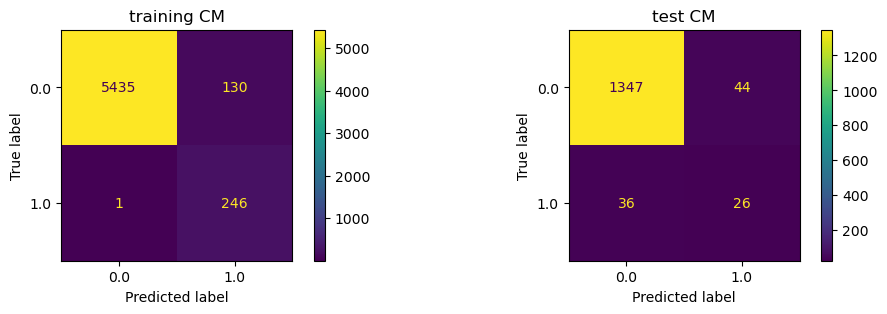

In [50]:
# plot the confusion matrices for training and test sets
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
# confusion matrix of the training set as the second subplot
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_train,y_pred_train, ax=ax3)
# set the title for the subplot
ax3.title.set_text('training CM')
# confusion matrix of the test set as the third subplot
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, ax=ax4)
ax4.title.set_text('test CM')

We now try to avoid overfitting using the early stopping method and dropout layers. We first split the old training set into a new training and validation set.

In [10]:
# prepare the data set
from sklearn.model_selection import train_test_split

# split the data set into training and validation sets
X_train1, X_val, y_train1, y_val = train_test_split(fp_train, y_train, train_size=0.8, shuffle=True, random_state=25)
# convert to tensors
tens_train1 = torch.tensor(X_train1, dtype=torch.float32)
tens_val = torch.tensor(X_val, dtype=torch.float32)
label_train1 = torch.tensor(y_train1.astype(int), dtype = torch.long)
label_val = torch.tensor(y_val.astype(int), dtype = torch.long)

# set up the minibatches and prepare the data loaders
batch_size = 50
rtrain = data.TensorDataset(tens_train1, label_train1)
rval = data.TensorDataset(tens_val, label_val)
rtest = data.TensorDataset(tens_test, label_test)
rloader_train = data.DataLoader(rtrain, batch_size=batch_size)
rloader_val = data.DataLoader(rval)


Early stopping at epoch 114
last epoch: 114
best n_epoch: 88
best validation RMSE = 1.119


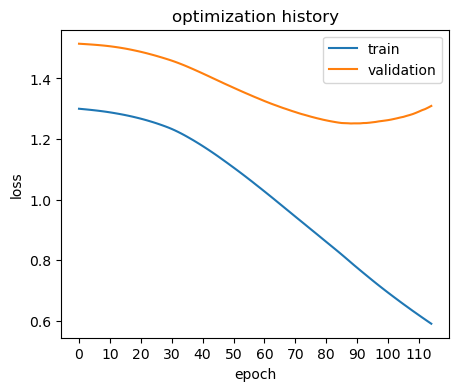

In [55]:
in_len = tens_train.shape[1]
out_len = 1
lr = 5e-6
dropout_ratio = 0.1
l1_strength = 1e-5
l2_strength = 1e-5
early_stopper_patience = 20
early_stopper_mindelta = 0.005
epochs = 400

# clear the variable if exists
try:
    del c_net
except:
    pass

c_net = NN_classification(in_len, out_len, dropout_ratio=dropout_ratio)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(c_net.parameters(), lr=lr)

trainloss_list = []
valloss_list = []
# initialize the variables used to store the validation stats and model parameters
weights_best = None
loss_best = np.inf
# set up the early stopping counter
stop_counter = EarlyStopper(patience=early_stopper_patience, min_delta=early_stopper_mindelta)


acc_list = []
prec_list = []
sens_list = []

for e in range(epochs):
    train_loss_adjusted, acc, prec, sens = train_loop(rloader_train, c_net, loss_fn, optimizer, l1=l1_strength, l2=l2_strength)
    train_loss = validation_loop(rloader_train, c_net, loss_fn)
    val_loss = validation_loop(rloader_val, c_net, loss_fn)
    trainloss_list.append(train_loss)
    valloss_list.append(val_loss)
    acc_list.append(acc)
    prec_list.append(prec)
    sens_list.append(sens)

    if val_loss < loss_best:
        loss_best = val_loss
        weights_best = c_net.state_dict()
    if stop_counter.early_stop(val_loss):
        print(f'Early stopping at epoch {e}')
        break

c_net.load_state_dict(weights_best) # load the best model parameters
print(f"last epoch: {e}") # number of cycles performed
print(f"best n_epoch: {valloss_list.index(loss_best)}\nbest validation RMSE = {np.sqrt(loss_best):.3f}")

# plot the optimization history
opt_plt = plt.figure(figsize=(5, 4))
plt.plot(trainloss_list, label="train")
plt.plot(valloss_list, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.xticks(range(0, e+1, 10))
plt.title("optimization history")
plt.legend()
plt.show()
# print(c_net(tens_train)) # check the output shape



Clearly improvement of model on the validation set stops after a limited amount of epochs, with the best epoch at 88. The model parameter were set back to the values at that epoch.

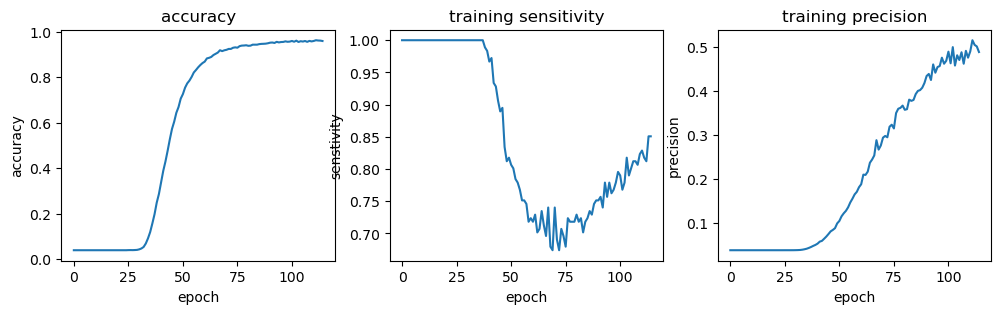

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
ax1.plot(acc_list)
ax1.title.set_text('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.plot(sens_list)
ax2.title.set_text('training sensitivity')
ax2.set_xlabel('epoch')
ax2.set_ylabel('senstivity')
ax3.plot(prec_list)
ax3.title.set_text('training precision')
ax3.set_xlabel('epoch')
ax3.set_ylabel('precision')
plt.show()

We check the model performance on the training data. Notice that an additional sigma function is performed on the outputs before calculating performance metrics. 

In [57]:
threshold = 0.5 # set the threshold for the sigmoid function

train_preds = torch.sigmoid(c_net(tens_train)) # calculate the predictions
# print(f'Predictions: {train_preds}')
y_pred_train = (train_preds > threshold).float() # convert the predictions to binary values
# print(f'Labels: {y_pred_train}')
test_preds = torch.sigmoid(c_net(tens_test)) # calculate the predictions
y_pred_test = (test_preds > threshold).float() # convert the predictions to binary values

# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   0.96   |     0.77    |    0.97     |   0.52
test   |   0.94   |     0.44    |    0.96     |   0.34

train F1-Score: 0.62
test F1-Score: 0.38


The sensitivity performance on the test set has increased further to 0.44. Meanwhile, the precision is still lower than for other models. Overfitting is clearly reduced.

Further hyperparameter tuning and cross-validation is necessary to improve the performance of the models. 